In [7]:
#!pip install -q condacolab
#import condacolab
#condacolab.install()

In [8]:
#!conda install -c sebp scikit-survival
#!pip install scikit-survival

# 1. Weibull

Commençons par l'estimation des paramètres d'une Weibull.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import weibull_min

%matplotlib inline

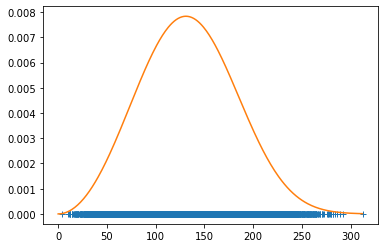

In [10]:
k = 3
lambda_w = 150

equipement_life = weibull_min.rvs(k, loc=0, scale=lambda_w, size=10000)
plt.plot(equipement_life, np.zeros(10000), '+')
d = np.arange(0, np.max(equipement_life))
survival = (k/lambda_w) * np.power((d/lambda_w),(k-1))*np.exp(-np.power((d/lambda_w), k))
plt.plot(d, survival)

1.1. Estimez k et lambda

estimation k: [[2.77738542]] estimation lambda: [[142.40020472]]


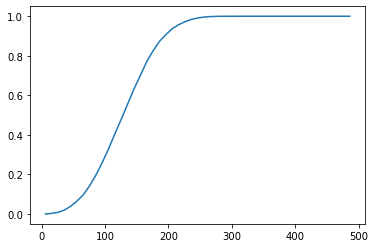

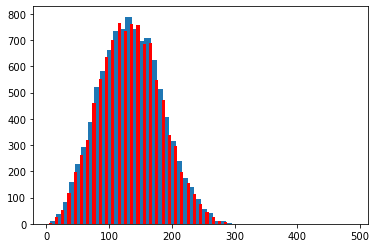

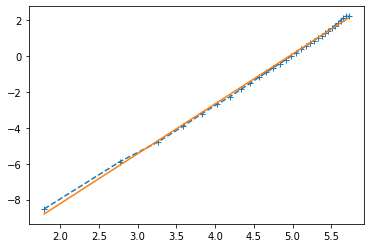

In [11]:
from sklearn.linear_model import LinearRegression
# Réponse
equipement_life = np.sort(equipement_life)
t = np.arange(1, 500, 10)
f, v = np.histogram(equipement_life, t)
F = np.cumsum(f)
F = F / 10000
plt.plot((v[0:-1]+v[1:])/2, F)
F_complet = F
t = (t[0:-1]+t[1:])/2
t_complet = t
t = t_complet[(1 - F_complet)>0]
F = F_complet[(1 - F_complet)>0]
logt = np.log(t)
loglogF = np.log(-np.log(1-F))
lr = LinearRegression()
lr.fit(logt.reshape(-1, 1), loglogF.reshape(-1, 1))
k_hat = lr.coef_
lambda_hat = np.exp(lr.intercept_/(-k_hat))

plt.figure()
plt.hist(equipement_life, t)
plt.bar((v[0:-1]+v[1:])/2, f, width=5, color='r')
plt.figure()
plt.plot(logt, loglogF,'+--')
plt.plot(logt, lr.predict(logt.reshape(-1, 1)));
print('estimation k:', k_hat, 'estimation lambda:', lambda_hat)

1.2.Estimez les valeurs de k et lambda par maximum de vraisemblance.

In [12]:
import scipy.optimize

# réponse
def F(k):
    return np.sum((equipement_life**k)\
                  * np.log(equipement_life))/np.sum((equipement_life**k)) \
                    - 1/k - np.mean(np.log(equipement_life))
k_hat = scipy.optimize.broyden1(F, [3], f_tol=1e-5)
print(k_hat)
lambda_hat = np.mean(equipement_life**k_hat)**(1/k_hat)

print(lambda_hat)

[3.01434069]
[150.39775465]


1.3. Faites varier le nombre d'échantillons, et comparez les deux méthodes.

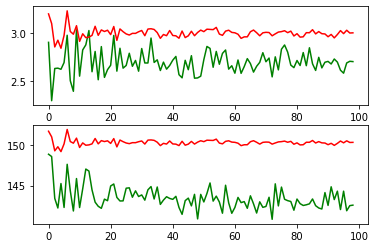

In [13]:
# Réponse
def estim_weibull_graph(samples):
    equipement_life = np.sort(samples)
    t = np.arange(1, np.max(samples), 10)
    f, v = np.histogram(equipement_life, t)
    F = np.cumsum(f)
    F = F / len(samples)
    F_complet = F
    t = (t[0:-1]+t[1:])/2
    t_complet = t
    t = t_complet[((1 - F_complet)>0)&(F_complet>0)]
    F = F_complet[((1 - F_complet)>0)&(F_complet>0)]
    logt = np.log(t)
    loglogF = np.log(-np.log(1-F))
    mf = LinearRegression()
    lr.fit(logt.reshape(-1, 1), loglogF.reshape(-1, 1))
    k_hat = lr.coef_
    lambda_hat = np.exp(lr.intercept_/(-k_hat))
    return k_hat, lambda_hat

def estim_weibull_ML(samples):
    def F(k):
        return np.sum((samples**k)*np.log(samples))/np.sum((samples**k)) - 1/k - np.mean(np.log(samples))
    k_hat = scipy.optimize.broyden1(F, [3], f_tol=1e-5)
    lambda_hat = np.mean(equipement_life**k_hat)**(1/k_hat)
    return k_hat, lambda_hat

range_to_test = range(100, 10000, 100)
k_hat_g = np.zeros(len(range_to_test))
k_hat_ml = np.zeros(len(range_to_test))
lambda_hat_g = np.zeros(len(range_to_test))
lambda_hat_ml = np.zeros(len(range_to_test))
for i, nb_samples in enumerate(range_to_test):
    samples = weibull_min.rvs(k, loc=0, scale=lambda_w, size=nb_samples)
    k_hat_g[i], lambda_hat_g[i] = estim_weibull_graph(samples)    
    k_hat_ml[i], lambda_hat_ml[i] = estim_weibull_ML(samples)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(k_hat_g, 'g')
plt.plot(k_hat_ml, 'r')
plt.subplot(2, 1, 2)
plt.plot(lambda_hat_g, 'g')
plt.plot(lambda_hat_ml, 'r');

# 2. Kaplan-Meier

2.1 Implémentez l'estimateur de Kaplan-Meier.

1 8 1 0.125 0.875
1 7 0.875 0.14285714285714285 0.8571428571428572
1 6 0.75 0.16666666666666666 0.8333333333333334
0 4 0.625 0.0 1.0
1 3 0.625 0.3333333333333333 0.6666666666666667
1 2 0.41666666666666674 0.5 0.5


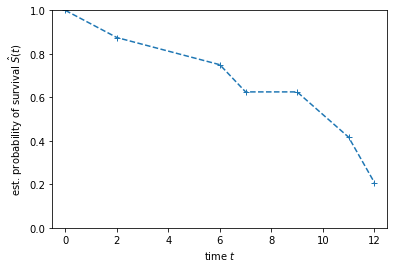

In [14]:
## Example Data 
durations = np.array([2,7,12,12,6,7,9, 11])
event_observed = np.array([1, 0, 0, 1, 1, 1, 0, 1])
# Réponse
S = [1]
for t in np.sort(np.unique(durations)):
    d = np.sum((durations == t) & (event_observed==1))
    n = np.sum(durations>=t)
    print(d, n, S[-1], d/n, (1-d/n))
    S.append(S[-1]*(1-d/n))
    
plt.plot(np.concatenate([[0], np.unique(durations)]), S, '--+');
plt.ylabel("est. probability of survival $\hat{S}(t)$");
plt.xlabel("time $t$");
plt.axis([-0.5, 12.5, 0, 1]);


2.2 Utilisez scikit-survival pour calculer un estimateur de Kaplan-Meier.

(-0.5, 12.5, 0.0, 1.0)

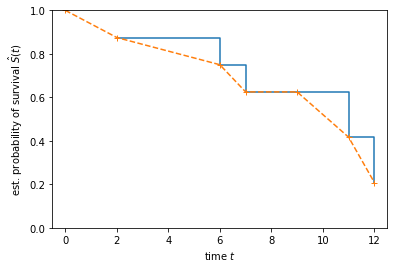

In [15]:
# Importing modules
import numpy as np
from matplotlib import pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(event_observed.astype(bool),
                                             durations)

plt.step(time, survival_prob, where="post")
plt.plot(np.concatenate([[0], np.unique(durations)]), S, '--+');
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.axis([-0.5, 12.5, 0, 1])


# 3 Influence des covariates

Nous prenons ici un dataset de maintenance prédictive. Il concerne un ensemble de machines, et leurs dates de panne. Il contient des descripteurs d'environnement, mais aussi des descripteurs sur qui a utilisé la machine (team) et qui l'a produite (provider). Nous ne nous occuperons que de la partie team & provider.

In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

raw_dataset = pd.read_csv('maintenance_.csv', sep=';')
raw_dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [45]:
time_column = 'lifetime'
event_column = 'broken'

categories = ['provider', 'team']
dataset = pd.get_dummies(raw_dataset, columns = categories)

Covariates = dataset.loc[: , ['provider_Provider1',
                              'provider_Provider2',
                              'provider_Provider3',
                              'provider_Provider4',
                              'team_TeamA',
                              'team_TeamB',
                              'team_TeamC']]

Time = dataset.loc[:, time_column]
Event = dataset.loc[:, event_column]
print(Covariates.head())

   provider_Provider1  provider_Provider2  provider_Provider3  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   1                   0                   0   
3                   0                   1                   0   
4                   1                   0                   0   

   provider_Provider4  team_TeamA  team_TeamB  team_TeamC  
0                   1           1           0           0  
1                   1           0           0           1  
2                   0           1           0           0  
3                   0           0           0           1  
4                   0           0           1           0  


3.1 Visualisez les données. 

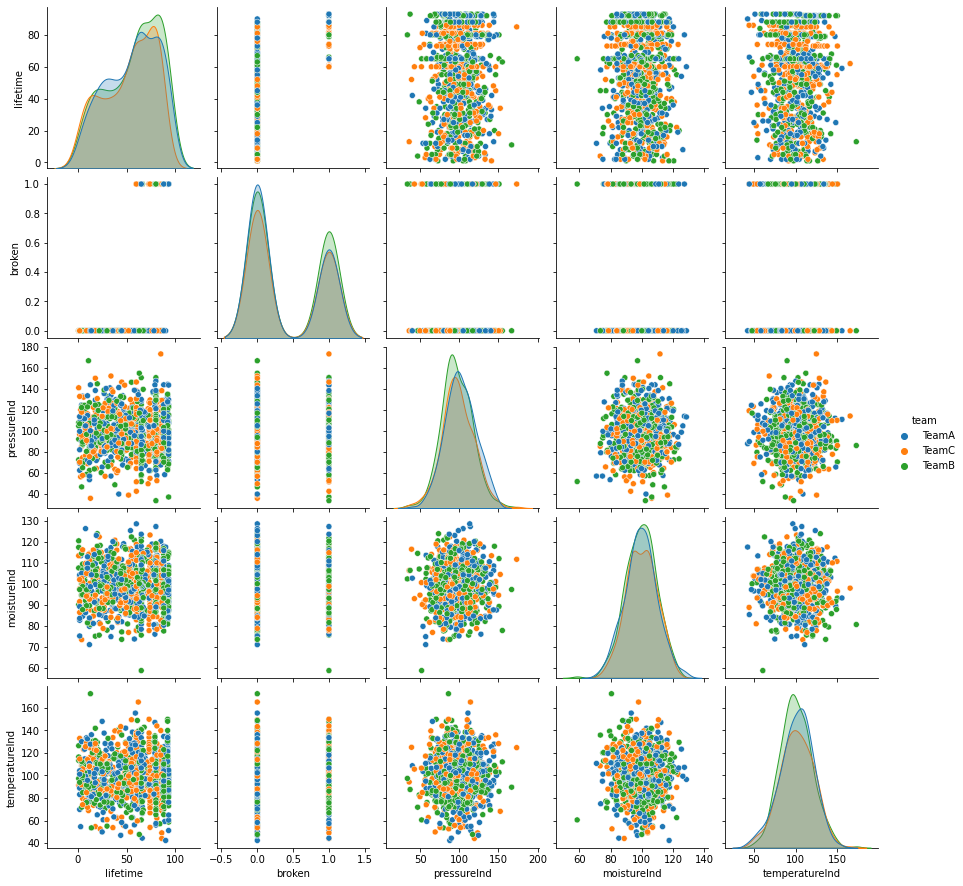

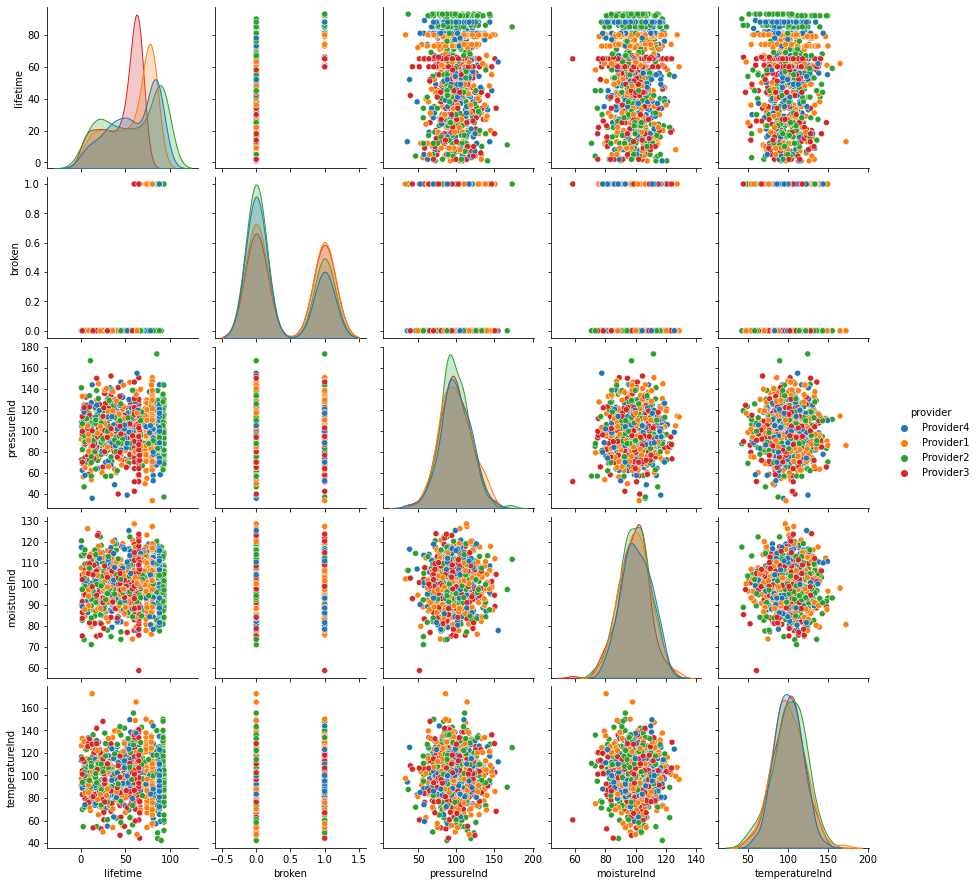

In [46]:
import seaborn as sns
sns.pairplot(raw_dataset.loc[:, ['lifetime', 'broken','pressureInd', 'moistureInd', 'temperatureInd', 'team']], hue='team');
sns.pairplot(raw_dataset.loc[:, ['lifetime', 'broken','pressureInd', 'moistureInd', 'temperatureInd', 'provider']], hue='provider');

3.2 Estimez les lois de vie pour les covariates suivants avec Kaplan-Meier et affichez les résultats sur une même figure : 
- provider
- team

team_TeamA
team_TeamB
team_TeamC


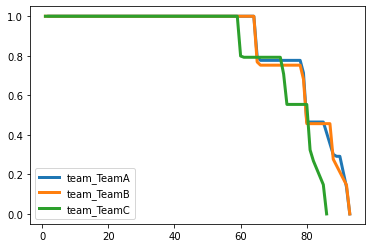

In [47]:
legends = []
for g in ['team_TeamA', 'team_TeamB', 'team_TeamC']:
    print(g)
    legends.append(g)
    durations = Time.loc[Covariates[g]==1]
    event = Event.loc[Covariates[g]==1]
    times, survival = kaplan_meier_estimator(event.astype(bool), durations)
    plt.plot(times, survival, label = g, lw = 3)
            
plt.legend(legends)

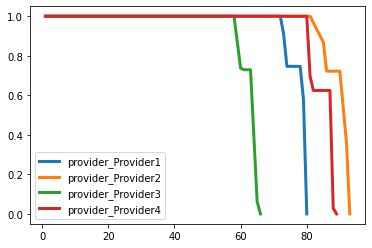

In [50]:
legends = []
plt.figure()
for g in ['provider_Provider1',
          'provider_Provider2',
          'provider_Provider3',
          'provider_Provider4']:
    legends.append(g)
    durations = Time.loc[Covariates[g]==1]
    event = Event.loc[Covariates[g]==1]
    times, survival = kaplan_meier_estimator(event.astype(bool), durations)
    plt.plot(times, survival, label = g, lw = 3)

plt.legend(legends);

3.3 Apprenez un modèle de Cox sur ces données. Analysez vos résultats en comparant les coefficients. Cela correspond-t-il aux courbes que vous avez observées ?

In [51]:
import warnings

def fxn():
    warnings.warn("LinAlgWarning", DeprecationWarning)



In [52]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
# Réponse
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    y =  [(e, t) for e, t in zip(Event.astype(bool), Time)]
    y = np.array(y, dtype=[('Event', 'b1'), ('Time', 'f4')])
    estimator = CoxPHSurvivalAnalysis().fit(Covariates, y)
    for name, coef in zip(Covariates.keys(), estimator.coef_):
        print(name, coef)

provider_Provider1 0.5477484015507751
provider_Provider2 -79.55152911090805
provider_Provider3 62.39938679176222
provider_Provider4 -59.22716394403839
team_TeamA -20.113371546131038
team_TeamB -20.11536368585368
team_TeamC 19.856475331998958


3.4. Calculer le Concordance-index sur le dataset.

In [53]:
# réponse
# Courte
estimator.score(Covariates, y)

# Détaillée
from sksurv.metrics import concordance_index_censored
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    y =  [(e, t) for e, t in zip(Event.astype(bool), Time)]
    y = np.array(y, dtype=[('Event', 'b1'), ('Time', 'f4')])

    cph = CoxPHSurvivalAnalysis().fit(Covariates, y)
    cindex, concordant, discordant, tied_risk, tied_time = concordance_index_censored(np.array(Event, dtype=bool),
                                   Time, estimate=cph.predict(Covariates), 
                                   tied_tol=1e-08)
    print('c-index:', cindex)
    print('concordant pairs:', concordant)
    print('paires avec le même risque:', tied_risk)
    print('paires avec le même temps:', tied_time)

c-index: 0.9796283181797414
concordant pairs: 84699
paires avec le même risque: 2131
paires avec le même temps: 1635


3.5 Apprenez un Random Survival Forest sur ce données et calculez le Concordance-index.

In [54]:
from sksurv.ensemble import RandomSurvivalForest
# Réponse
y =  [(e, t) for e, t in zip(Event.astype(bool), Time)]
y = np.array(y, dtype=[('Event', 'b1'), ('Time', 'f4')])
estimator = RandomSurvivalForest().fit(Covariates, y)
estimator.score(Covariates, y)

0.9463437200164481

3.6 Comparez plus rigoureusement les deux modèles, par 2 changements dans l'analyse.

In [56]:
# Les 2 changements : ajouter une métrique, ajouter une séparation train / test
from sklearn.model_selection import train_test_split
from sksurv.metrics import integrated_brier_score

nb_test = 5
all_cph_ci = np.zeros(nb_test)
all_rsf_ci = np.zeros(nb_test)
all_cph_bs = np.zeros(nb_test)
all_rsf_bs = np.zeros(nb_test)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i, rs in enumerate(range(0, nb_test)):
        X_train, X_test, time_train, time_test = train_test_split(Covariates, Time, random_state=rs, test_size=0.5)
        X_train, X_test, event_train, event_test = train_test_split(Covariates, Event, random_state=rs, test_size=0.5)

        y_train =  [(e, t) for e, t in zip(event_train.astype(bool), time_train)]
        y_train = np.array(y_train, dtype=[('Event', 'b1'), ('Time', 'f4')])
        y_test =  [(e, t) for e, t in zip(event_test.astype(bool), time_test)]
        y_test = np.array(y_test, dtype=[('Event', 'b1'), ('Time', 'f4')])
        cph = CoxPHSurvivalAnalysis().fit(X_train, y_train)
        c_index_cph = cph.score(X_test, y_test)

        times = np.arange(np.min(time_test[event_test>0]), np.max(time_test))

        survs = cph.predict_survival_function(X_test)
        preds = np.asarray([[fn(t) for t in times] for fn in survs])
        print(preds[0][0])
        bs_cph = integrated_brier_score(y_train, y_test, preds, times)

        rsf = RandomSurvivalForest(n_estimators=200).fit(X_train, y_train)
        c_index_rsf = rsf.score(X_test, y_test)

        survs = rsf.predict_survival_function(X_test)
        preds = np.asarray([[fn(t) for t in times] for fn in survs])
        bs_rsf = integrated_brier_score(y_train, y_test, preds, times)
        print('CI: Cox Model:', "%0.3f" % c_index_cph, 'SRF:', "%0.3f" % c_index_rsf)
        print('IBS: Cox Model:', "%0.3f" % bs_cph, 'SRF:', "%0.3f" % bs_rsf)
        all_cph_ci[i] = c_index_cph
        all_rsf_ci[i] = c_index_rsf
        all_cph_bs[i] = bs_cph
        all_rsf_bs[i] = bs_rsf

    print('Cox Model:', "CI %0.3f" % np.mean(all_cph_ci), '+/-', "%0.3f" % np.std(all_cph_ci), "IBS: %0.3f" % np.mean(all_cph_bs), '+/-', "%0.3f" %np.std(all_cph_bs),
          'SRF:',  "CI %0.3f" % np.mean(all_rsf_ci), '+/-',  "%0.3f" %np.std(all_rsf_ci),   "IBS:  %0.3f" % np.mean(all_rsf_bs), '+/-',  "%0.3f" %np.std(all_rsf_bs),)

0.0


ValueError: Input estimate contains infinity or a value too large for dtype('float64').

In [34]:
print('Cox was better in CI for :', "%0.0f" % (100*np.mean(all_cph_ci > all_rsf_ci)), '%')
print('Cox was better in IBS for :', "%0.0f" % (100*np.mean(all_cph_bs < all_rsf_bs)), '%')

Cox was better in CI for : 100 %
Cox was better in IBS for : 0 %


3.7 Analysez vos résultats

In [57]:
from sksurv.metrics import integrated_brier_score
rs = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    X_train, X_test, time_train, time_test = train_test_split(Covariates, Time, random_state=rs, test_size=0.5)
    X_train, X_test, event_train, event_test = train_test_split(Covariates, Event, random_state=rs, test_size=0.5)

    y_train =  [(e, t) for e, t in zip(event_train.astype(bool), time_train)]
    y_train = np.array(y_train, dtype=[('Event', 'b1'), ('Time', 'f4')])
    y_test =  [(e, t) for e, t in zip(event_test.astype(bool), time_test)]
    y_test = np.array(y_test, dtype=[('Event', 'b1'), ('Time', 'f4')])
    cph = CoxPHSurvivalAnalysis().fit(X_train, y_train)
    c_index_cph = cph.score(X_test, y_test)

    times = np.arange(np.min(time_test[event_test>0]), np.max(time_test))

    survs = cph.predict_survival_function(X_test)
    preds = np.asarray([[fn(t) for t in times] for fn in survs])
    bs_cph = integrated_brier_score(y_train, y_test, preds, times)
    for s in survs:
        plt.plot(s.x, s(s.x),'-ok')

    rsf = RandomSurvivalForest(n_estimators=200).fit(X_train, y_train)
    c_index_rsf = rsf.score(X_test, y_test)

    survs = rsf.predict_survival_function(X_test)
    for s in survs:
        plt.plot(s.x, s(s.x),'-og')

    preds = np.asarray([[fn(t) for t in times] for fn in survs])
    bs_rsf = integrated_brier_score(y_train, y_test, preds, times)
    print('CI: Cox Model:', "%0.3f" % c_index_cph, 'SRF:', "%0.3f" % c_index_rsf)
    print('IBS: Cox Model:', "%0.3f" % bs_cph, 'SRF:', "%0.3f" % bs_rsf)
    all_cph_ci[i] = c_index_cph
    all_rsf_ci[i] = c_index_rsf
    all_cph_bs[i] = bs_cph
    all_rsf_bs[i] = bs_rsf

ValueError: Input estimate contains infinity or a value too large for dtype('float64').

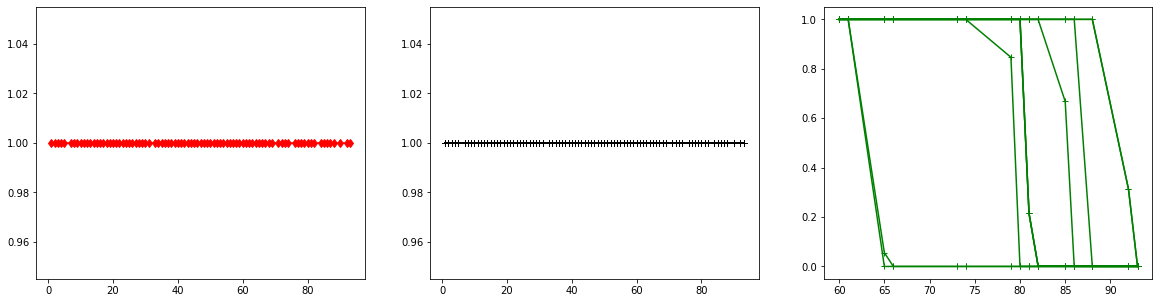

In [102]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(cph.baseline_survival_.x, cph.baseline_survival_.y, 'r-d')
cph_predictions = cph.predict_survival_function(X_test.iloc[0:10, :])
plt.subplot(1, 3, 2)
for cp in cph_predictions:
    plt.plot(cp.x, cp(cp.x), '-+k')
rsf_predictions = rsf.predict_survival_function(X_test.iloc[0:10, :])
plt.subplot(1, 3, 3)
for rs in rsf_predictions:
    plt.plot(rs.x, rs(rs.x), '-+g')

(0.0, 93.0)

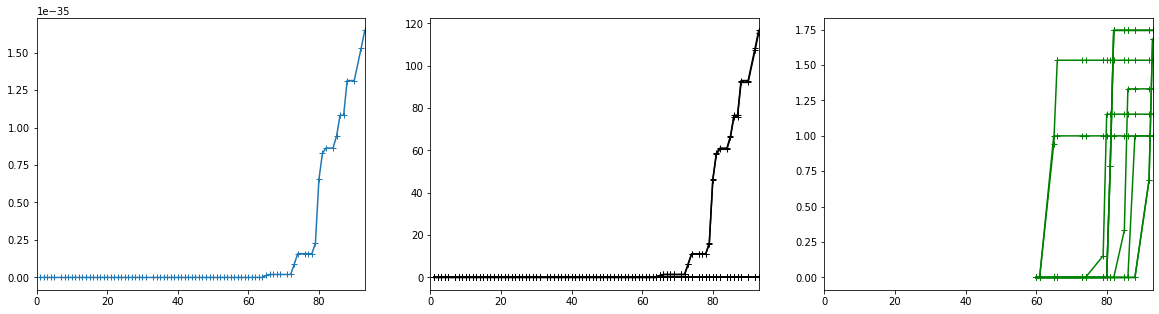

In [103]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(cph.cum_baseline_hazard_.x, cph.cum_baseline_hazard_.y, '-+')
cph_predictions = cph.predict_cumulative_hazard_function(X_test.iloc[0:10, :])
plt.xlim([0, 93])
for cp in cph_predictions:
    plt.subplot(1, 3, 2)
    plt.plot(cp.x, cp(cp.x), '-+k')
rsf_predictions = rsf.predict_cumulative_hazard_function(X_test.iloc[0:10, :])
plt.xlim([0, 93])
for rs in rsf_predictions:
    plt.subplot(1, 3, 3)
    plt.plot(rs.x, rs(rs.x), '-+g')
plt.xlim([0, 93])

In [105]:
# Pour calcul ibs :
from sksurv.metrics import integrated_brier_score
times = np.arange(np.min(Time[Event>0]), np.max(Time))
survs = estimator.predict_survival_function(Covariates)
print(times)
print(survs[0])
preds = np.asarray([[fn(t) for t in times] for fn in survs])
bs_rsf = integrated_brier_score(y, y, preds, times)
print(bs_rsf)

[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92]
StepFunction(x=array([60., 61., 65., 66., 73., 74., 79., 80., 81., 82., 85., 86., 88.,
       89., 92., 93.]), y=array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.04885075, 0.        , 0.        ,
       0.        ]), a=1.0, b=0.0)
0.003968477200391319


c-index: 0.9796283181797414
concordant pairs: 84699
tied risk: 2131
tied time: 1635


(90,)